# Capstone Project

* Kevin Gross
* Part Time Flatiron School Student

# Movie Recommendation System

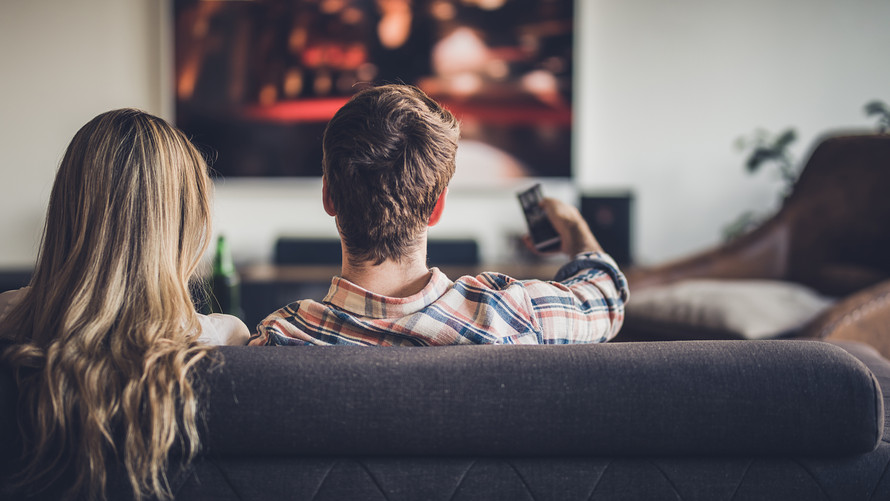

## Overview

At first thought, recommendation systems have a very simple goal: **expose people to items that they will like**. However, there is much more that goes into a recommendation system behind the scenes.

From a data science definition, a recommendation system predicts the future preference of a set of items for a user, and recommends the top items from this set. In today's world, due to the internet and its global reach, people have more options to choose from than ever before.

Here's a formal definition of recommendation systems from authors [Bo Xiao and Izak Benbasat, 2017](https://misq.umn.edu/e-commerce-product-recommendation-agents-use-characteristics-and-impact.html):

> "Recommendation Systems are software agents that elicit the interests and preferences of individual consumers […] and make recommendations accordingly. They have the potential to support and improve the quality of the decisions consumers make while searching for and selecting products online."

## Recommendation System Approaches

There are two main types of recommendation systems: **unpersonalized** and **personalized**. This project will focus on personalized recommendation systems because that's where data scientists can provide the most value to companies, but to start off, let's investigate some unpersonalized systems because they can be productive in their own right.

### Type #1: Unpersonalized Recommendations

Unpersonalized recommendation systems have been happening since way before machine learning was ever in the public knowledge base. An example of an unpersonalized recommendation would be on YouTube when it recommends the most viewed videos. These are videos that the most people have watched. For the most part, these recommendations aren't too bad. After all, there's a reason why things are popular. This approach, however, is not going to help more niche videos get exposure. It also won't be immensely beneficial to those who have very particular tastes. Of course, there are times when a simple approach like this might be best. An example of a simple popularity recommender working well is with the news. There's a high chance that everyone who visits a news website is going to want to see whatever is the most popular at that moment in time.

### Type #2: Personalized Recommendations

According to Todd Yellin, Netflix’s vice president of product innovation:

> “Personalization is about creating the right connection between a viewer and their content.”
> [SOURCE](https://www.altexsoft.com/blog/recommender-system-personalization/)

In other words, personalization is the way to match the right types of services, products, or content to the right users. When approached appropriately, it helps improve user engagement — any interactions people have with a product, website, app, etc.

These days, the true power of customer experience personalization can be realized with the help of machine learning. By utilizing ML algorithms and data, it is possible to create smart models that can precisely predict customer intent and as such provide quality one-to-one recommendations.

At the same time, the continuous growth of available data has led to information overload — when too many choices complicate decision-making. Primarily developed to help users deal with the large range of choices they encounter, recommender systems come into play.

Recommender systems, also known as recommender engines, are information filtering systems that provide individual recommendations in real-time. As powerful personalization tools, recommendation systems leverage machine learning algorithms and techniques to give the most relevant suggestions to particular users by learning data (e.g., past behaviors) and predicting current interests and preferences.

<div>
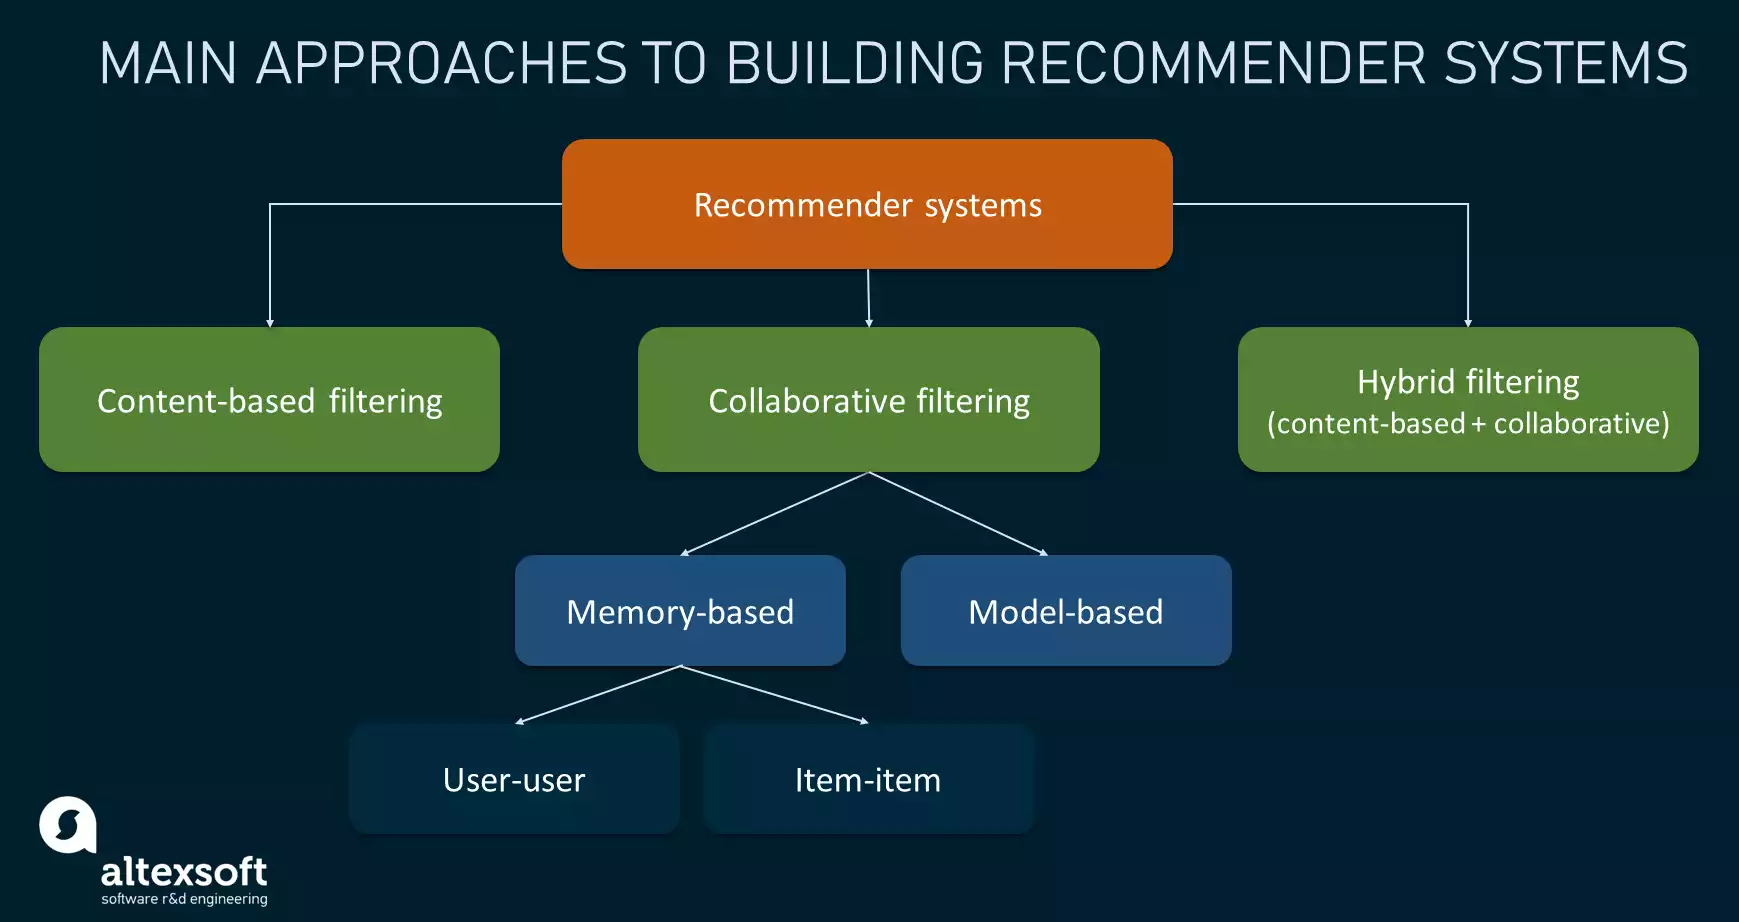
</div>

## Approaches

This project is going to use all 3 main approaches to predict what movie a user would prefer:

* **Content-based filtering**, which generates predictions by analyzing item attributes and searching for similarities between them
* **Collaborative filtering**, which generates predictions by analyzing user behavior and matching users with similar tastes
* **Hybrid filtering**, which combines two or more models.

Now that we have a general overview of what a recommendation system is and how it works, let's dive in to our data.

## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import squarify
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import mean_squared_error
from surprise import Reader, Dataset, KNNBasic, KNNBaseline, SVD, KNNWithMeans, accuracy
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.model_selection import train_test_split as train_test_split_surprise
import string
import re
%matplotlib inline

## Load the Data

This project is going to use 4 datasets, some of which have multiple files within them:

1. [Wikipedia Movie Plots](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots)
  * `wiki_movie_plots_deduped`
2. [MovieLens 100K](https://grouplens.org/datasets/movielens/latest/)
  * `links`
  * `movies`
  * `ratings`
  * `tags` - I DONT THINK WE NEED THIS
3. [IMDB](https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset)
  * `ratings_data`
  * `basic_name_data` - I DONT THINK WE NEED THIS
  * `title_basics_data`
  * `title_data` - I DONT THINK WE NEED THIS
  * `title_principals_data` - I DON'T THINK WE NEED THIS
4. [Streaming Platforms](https://www.kaggle.com/datasets/javagarm/movies-on-ott-platforms)
  * `MoviesOnStreamingPlatforms_updated`

## Wikipedia Data

There is 1 file within the Wikipedia Data set: `wiki_movie_plots_deduped`.

In [2]:
# Load the data
plots_df = pd.read_csv('Data/Wikipedia Movie Plots/wiki_movie_plots_deduped.csv')

# Preview the data
plots_df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


The first type of model we are going to build will use content-based collaborative filtering, specifically on the `Plot` column. Before doing that, let's take a closer look at our data.

# Preliminary Exploratory Data Analysis

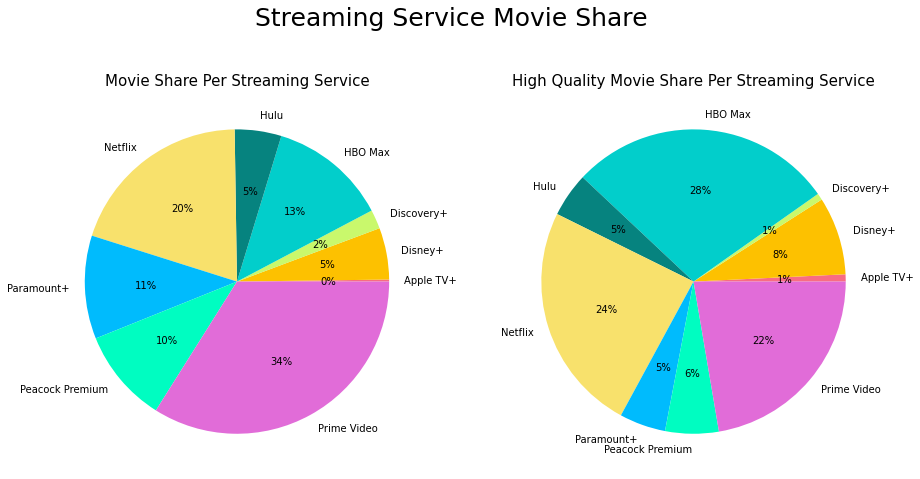

In [143]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))

# Define data
total_movies = [44, 1129, 417, 2586, 1019, 4091, 2257, 2051, 6985]
high_quality_movies = [14, 152, 13, 517, 86, 447, 90, 104, 409]
labels = ['Apple TV+', 'Disney+', 'Discovery+', 'HBO Max', 'Hulu', 'Netflix', 
          'Paramount+', 'Peacock Premium', 'Prime Video']

colors= ['#f86c83', '#fdc100', '#c9f86c', '#02cecb', '#06837f', '#f8e16c', '#00bbfd', '#00fdc1', '#e16cd8']

# Create pie chart
fig.suptitle("Streaming Service Movie Share", fontsize=25)

ax1.pie(total_movies, labels = labels, colors = colors, autopct='%.0f%%')
ax1.set_title("Movie Share Per Streaming Service", fontsize=15)

ax2.pie(high_quality_movies, labels = labels, colors = colors, autopct='%.0f%%')
ax2.set_title("High Quality Movie Share Per Streaming Service", fontsize=15)

plt.show()

In [3]:
# Check for missing values
plots_df.isna().sum()

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64

In [4]:
# Value counts of `Genre`
plots_df['Genre'].value_counts()

unknown                          6083
drama                            5964
comedy                           4379
horror                           1167
action                           1098
                                 ... 
cbc-tv miniseries                   1
bio-drama                           1
national film board docudrama       1
cult drama                          1
horror romantic comedy              1
Name: Genre, Length: 2265, dtype: int64

Even though we only have missing values in the `Cast` column, we can see above that we are missing plenty of information in the `Genre` column as well because it includes the entry `unknown`. Let's take a look at our dataframe in a bit further detail.

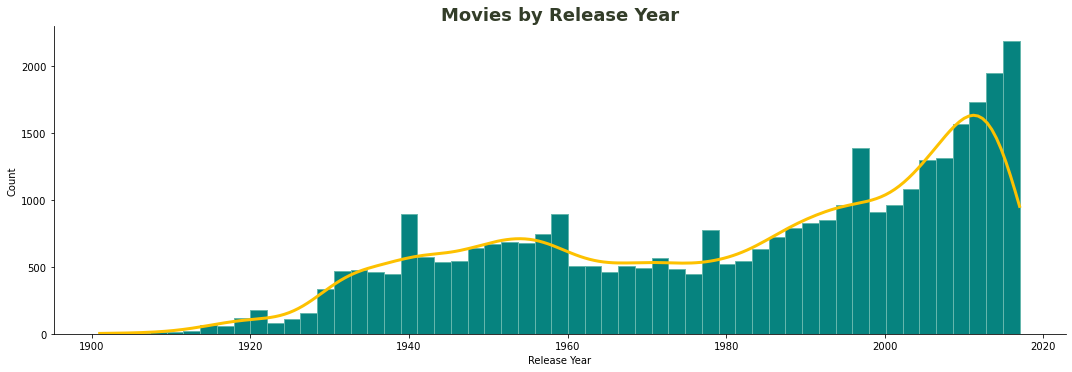

In [5]:
# Create displot
sns.displot(data=plots_df, x='Release Year', kind='hist', kde=True, bins=55,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)

# Label our headings
plt.title('Movies by Release Year', fontsize=18, weight=600, color='#333d29');

It looks like our movies by release year is skewed left. Or in other words, we have more movies released in the current era, which does make sense when you think about it logically.

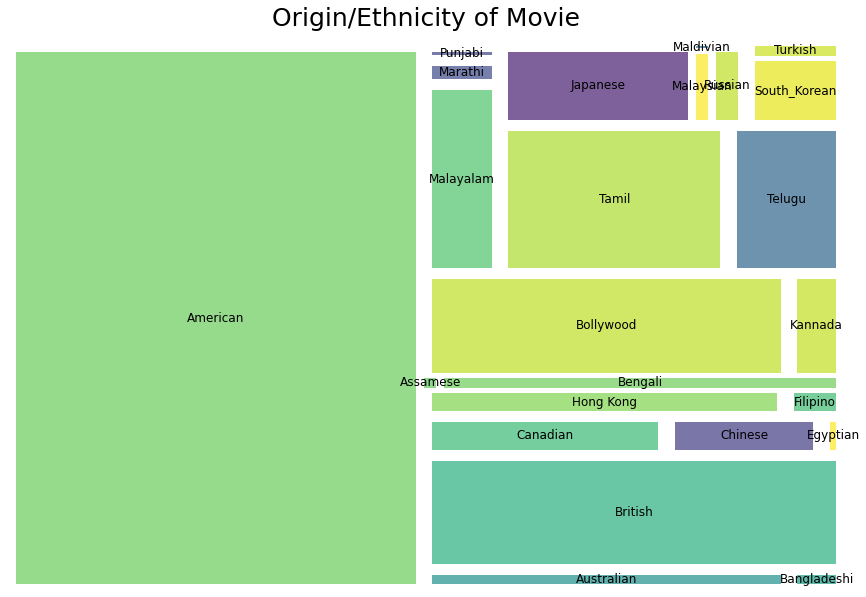

In [6]:
# Count origin column
origin_info = Counter(plots_df['Origin/Ethnicity'])

# Create plot
plt.figure(figsize=(15, 10))
plt.title("Origin/Ethnicity of Movie", fontsize=25, pad=20)
squarify.plot(origin_info.values(), label=origin_info.keys(), text_kwargs={'fontsize':12}, 
              bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off");

We can see that the vast majority of our movies are American. 

Now that we have a decent understanding of our first dataframe, let's move onto our first model.

# Modeling

Let's recall our graph and goals for this project. 

* **Content-based filtering**, which generates predictions by analyzing item attributes and searching for similarities between them
* **Memory-based Collaborative filtering**, which generates predictions by analyzing user behavior and matching users with similar tastes
* **Hybrid filtering**, which combines two or more models.

# Content-based Filtering

The first recommender system we are going to create is **content-based**. For this model, we will first generate recommendations of movies based on a watched movie. From there, we will recommend movies based on the genre of a watched movie.

## TF-IDFVectorizer

Not all words in a document carry equal weight. We know this from looking at stopwords. But the words that were in the vocabulary were all given equal weighting.

Should this always be the case...?

For example, consider a corpus of documents on dogs. Now, it is obvious that all these documents will frequently contain the word dog. Therefore, the appearance of the word dog isn't as important as another word that only appears in a few documents.

**TF-IDFVectorizer (Term Frequency-Inverse Document Frequency)** takes the aforementioned point into consideration and assigns weights to each word according to the following formula.

$$\large IDF(t) = log_e(\frac{Total\ Number\ of\ Documents}{Number\ of\ Documents\ with\ t\ in\ it})$$

[SCIKIT LEARN DOCUMENTATION](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Just keep in mind that the weight of a word in a document is greater if it occurs more frequently in that document and is present in fewer documents. The weight takes values between 0 and 1.

We will be using TF-IDFVectorizer because some words occur much more frequently in plot descriptions than others. It is therefore a good idea to assign weights to each word in a document according to the TF-IDF formula. Another reason to use TF-IDF is that it speeds up the calculation of the cosine similarity score between a pair of documents. 

We will mainly use the `Plot` information from our `non_dup_movies` dataframe. First, we will clean up the `Plot` column by lowering the case of all of the words and removing the punctuation. From there we will fit and transform the `Clean_Plot` column using a `TfidfVectorizer`. 

## Cosine Similarity Score

The cosine score is extremely robust and easy to calculate (especially when used in conjunction with TF-IDFVectorizer).

The cosine similarity score between two documents, x and y, is as follows:

$$\large cosine(x,y) = \frac{X \cdot y^T}{\parallel x \parallel \cdot \parallel y \parallel}$$

The cosine score can take any value between -1 and 1. The higher the cosine score, the more similar the documents are to each other. We now have a good theoretical base to proceed to build the content-based recommenders using Python.

## Plot description-based recommender

Our plot description-based recommender will take in a movie title as an argument and output a list of movies that are most similar based on their plots. These are the steps we are going to perform in building this model:

1. Obtain the data required to build the model
2. Create TF-IDF vectors for the plot description (or overview) of every movie
3. Compute the pairwise cosine similarity score of every movie
4. Write the recommender function that takes in a movie title as an argument and outputs movies most similar to it based on the plot

In [7]:
# Display our dataframe
plots_df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [8]:
# Standardize the case for our `Plot`
plots_df['Clean_Plot'] = plots_df['Plot'].str.lower()

# Remove punctuation
plots_df['Clean_Plot'] = plots_df['Clean_Plot'].str.translate(str.maketrans('', '', string.punctuation))

In [9]:
# Instantiate a vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on plots_df['Clean_Plot'] and transform it
movies_vectorized = tfidf.fit_transform(plots_df['Clean_Plot'])

# Preview the shape
movies_vectorized.shape

(34886, 178166)

We can see that the vectorizer has created a 178,166-dimensional vector for the overview of every movie.

### Compute the Cosine Similarity Score

The next step is to calculate the pairwise cosine similarity score of every movie. In other words, we are going to create a 34,886 × 34,886 matrix, where the cell in the ith row and jth column represents the similarity score between movies i and j. We can easily see that this matrix is symmetric in nature and every element in the diagonal is 1, since it is the similarity score of the movie with itself.

Like `TF-IDFVectorizer`, scikit-learn also has functionality for computing the aforementioned similarity matrix. Calculating the cosine similarity is, however, a computationally expensive process. Fortunately, since our movie plots are represented as TF-IDF vectors, their magnitude is always 1. Hence, we do not need to calculate the denominator in the cosine similarity formula as it will always be 1. Our work is now reduced to computing the much simpler and computationally cheaper dot product (a functionality that is also provided by scikit-learn).

In [10]:
# Apply `linear_kernel` to our vector
cosine_sim = linear_kernel(movies_vectorized, movies_vectorized)

# Preview the results
cosine_sim

array([[1.        , 0.03026373, 0.00777599, ..., 0.        , 0.00371386,
        0.        ],
       [0.03026373, 1.        , 0.00892876, ..., 0.        , 0.01005604,
        0.0191672 ],
       [0.00777599, 0.00892876, 1.        , ..., 0.00766691, 0.00622522,
        0.        ],
       ...,
       [0.        , 0.        , 0.00766691, ..., 1.        , 0.0115371 ,
        0.00613037],
       [0.00371386, 0.01005604, 0.00622522, ..., 0.0115371 , 1.        ,
        0.00300791],
       [0.        , 0.0191672 , 0.        , ..., 0.00613037, 0.00300791,
        1.        ]])

With the similarity scores of every movie with every other movie, we are now in a very good position to write our final recommender function.

### Building the recommender function

The final step is to create our recommender function. However, before we do that, let's create a reverse mapping of movie titles and their respective indices. In other words, let's create a pandas series with the index as the movie title and the value as the corresponding index in the main DataFrame:

In [11]:
# Create variable `indices` to pull the index of each movie
indices = pd.Series(plots_df.index, index=plots_df['Title']).drop_duplicates()

# Preview the results
indices

Title
Kansas Saloon Smashers                  0
Love by the Light of the Moon           1
The Martyred Presidents                 2
Terrible Teddy, the Grizzly King        3
Jack and the Beanstalk                  4
                                    ...  
The Water Diviner                   34881
Çalgı Çengi İkimiz                  34882
Olanlar Oldu                        34883
Non-Transferable                    34884
İstanbul Kırmızısı                  34885
Length: 34886, dtype: int64

We will perform the following steps in building the recommender function:

1. Declare the title of the movie as an argument.
2. Obtain the index of the movie from the indices reverse mapping.
3. Get the list of cosine similarity scores for that particular movie with all movies using cosine_sim. Convert this into a list of tuples where the first element is the position and the second is the similarity score.
4. Sort this list of tuples on the basis of the cosine similarity scores.
5. Get the top 10 elements of this list. Ignore the first element as it refers to the similarity score with itself (the movie most similar to a particular movie is obviously the movie itself).
6. Return the titles corresponding to the indices of the top 10 elements, excluding the first:

In [12]:
def get_recommendations(title, cosine_sim, df, indices):
    
    # Obtain the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies, ignore the first movie
    sim_scores = sim_scores[1:11]
    
    # Find the movies that match with those indicies
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return pd.DataFrame(df['Title'].iloc[movie_indices])

Let's try it out!

In [13]:
get_recommendations('Toy Story', cosine_sim, plots_df, indices)

,Title
13574,Toy Story 2
5342,Destination Meatball
15948,Toy Story 3
5203,Puny Express
16619,Nebraska
16606,LUV
3731,The Barber of Seville
2811,Girl from Havana
6608,Mr. B Natural
22145,It's a Boy Girl Thing


We see that our recommender has suggested all of Toy Story's sequels in its top-10 list. 

It goes without saying that a person who loves Toy Story is very likely to have a thing for Disney movies. They may also prefer to watch animated movies. Unfortunately, our plot description recommender isn't able to capture all this information.

Therefore next we will build a recommender that uses more advanced metadata, such as genres, cast, crew, and keywords (or sub-genres). This recommender will be able to do a much better job of identifying an individual's taste for a particular director, actor, sub-genre, and so on.

# Metadata-based Recommender

To build this model, we will be using the following metdata:

* The genre of the movie
* The director of the movie
* Major stars and cast

## IMDB Dataset

Now we are going to load in information from our second dataset, The IMDB Data set. There are 5 files located within this dataset:

  * `ratings_data`
  * `basic_name_data`
  * `title_basics_data`
  * `title_data` -- I DON'T THINK WE NEED THIS
  * `title_principals_data` 

In [14]:
# Load the data
imdb_ratings_df = pd.read_csv('Data/IMDB/ratings_data.tsv', sep='\t')

# Preview the data
imdb_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1923
1,tt0000002,5.8,259
2,tt0000003,6.5,1737
3,tt0000004,5.6,174
4,tt0000005,6.2,2550


In [15]:
# Load the data
name_df = pd.read_csv('Data/IMDB/basic_name_data.tsv', sep='\t')

# Preview the data
name_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0050419,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0038355,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0056404,tt0057345,tt0049189,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0080455,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986"


In [16]:
# Load the data
title_basics_df = pd.read_csv('Data/IMDB/title_basics_data.tsv', sep='\t', low_memory=False)

# Preview the data
title_basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [17]:
# Load the data
title_principals_df = pd.read_csv('Data/IMDB/title_principals_data.tsv', sep='\t')

# Preview the data
title_principals_df

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N
...,...,...,...,...,...,...
53173242,tt9916880,4,nm10535738,actress,\N,"[""Horrid Henry""]"
53173243,tt9916880,5,nm0996406,director,principal director,\N
53173244,tt9916880,6,nm1482639,writer,\N,\N
53173245,tt9916880,7,nm2586970,writer,books,\N


Before merging this dataset with our `plots_df` we need to filter and merge the IMDB dataset and clean it up.

## Merge The Datasets

Now that we have all of our data loaded, we need to start organizing them into forms that will work for our recommendation engines and also merge them into one big dataframe.

Let's start with the `title_basics_df`.

In [18]:
print('Title Basics Dataframe Shape:', title_basics_df.shape, '\n')

# Preview types of titles
print(title_basics_df['titleType'].value_counts())

Title Basics Dataframe Shape: (9389356, 9) 

tvEpisode       7091360
short            901062
movie            627705
video            267519
tvSeries         234495
tvMovie          138357
tvMiniSeries      46065
tvSpecial         39207
videoGame         32838
tvShort           10746
tvPilot               2
Name: titleType, dtype: int64


As we can see above, `title_basics_df` includes amost 10 million rows with all types of media options:

* `tvEpisode`
* ` short`
* `movie`
* `video`
* `tvSeries`
* `tvMovie`
* `tvMiniSeries`
* `tvSpecial`
* `videoGame`
* `tvShort`
* `tvPilot`

We are only interested in the `movie` title type so let's filter down this dataframe to only include those options.

In [19]:
# Filter titles to only contain 'movies'
title_basics_df = title_basics_df.loc[title_basics_df['titleType'].str.contains('movie')]

# Preview the filtering
title_basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


In [20]:
# Check if it worked
title_basics_df['titleType'].value_counts()

movie    627705
Name: titleType, dtype: int64

Now that we only have the titleType of `movies` let's start pairing this dataframe down to only the information we need and work on merging it with the other dataset from IMDB. Luckily, it looks like we have a matching column in both dataframes titled `tconst`.

In [21]:
# Merge the datasets on `tconst`
imdb_df = pd.merge(title_basics_df, imdb_ratings_df, on='tconst')

# Preview new dataframe
imdb_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,200
1,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.2,14
2,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,796
3,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.1,20
4,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,4.3,23


In [22]:
imdb_df.drop(columns=['titleType', 'originalTitle', 'isAdult'], axis=1, inplace=True)

In [23]:
# Checking for missing values
imdb_df.isna().sum()

tconst            0
primaryTitle      0
startYear         0
endYear           0
runtimeMinutes    0
genres            0
averageRating     0
numVotes          0
dtype: int64

Great. Now that we have that dataframe paired down, we are going to try to do the same with the `title_principals_df`.

In [24]:
print('Title Principals Dataframe Shape:', title_principals_df.shape, '\n')

# Preview types of titles
print(title_principals_df['category'].value_counts())

Title Principals Dataframe Shape: (53173247, 6) 

actor                  11746301
self                    9236787
actress                 9068782
writer                  7415603
director                6137518
producer                3440477
cinematographer         1838693
composer                1811735
editor                  1776215
production_designer      352295
archive_footage          345094
archive_sound              3747
Name: category, dtype: int64


Wow, this dataframe is over 53 million rows long! Luckily we only need one of the columns: `director`.

In [25]:
# Filter titles to only contain 'movies'
title_principals_df = title_principals_df.loc[title_principals_df['category'].str.contains('director')]

# Preview the filtering
print('Shape of dataframe', title_principals_df.shape)
title_principals_df.head()

Shape of dataframe (6137518, 6)


,tconst,ordering,nconst,category,job,characters
1,tt0000001,2,nm0005690,director,\N,\N
3,tt0000002,1,nm0721526,director,\N,\N
5,tt0000003,1,nm0721526,director,\N,\N
9,tt0000004,1,nm0721526,director,\N,\N
13,tt0000005,3,nm0005690,director,\N,\N


We can see that we have now paired this down to just over 6 million directors. Let's pull out the columns we need and merge this with our `name_df` to get each director's name.

In [26]:
# Drop unnecessary columns
directors_df = title_principals_df[['tconst', 'nconst']]

# Preview data
directors_df.head()

,tconst,nconst
1,tt0000001,nm0005690
3,tt0000002,nm0721526
5,tt0000003,nm0721526
9,tt0000004,nm0721526
13,tt0000005,nm0005690


In [27]:
# Drop unnecessary columns
name_df.drop(columns=['birthYear', 'deathYear'], axis=1, inplace=True)

# Preview data
name_df.head()

,nconst,primaryName,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0050419,tt0031983"
1,nm0000002,Lauren Bacall,"actress,soundtrack","tt0117057,tt0038355,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,"actress,soundtrack,music_department","tt0056404,tt0057345,tt0049189,tt0054452"
3,nm0000004,John Belushi,"actor,soundtrack,writer","tt0078723,tt0080455,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986"


In [28]:
# Merge dataframes
dir_name_df = pd.merge(name_df, directors_df, on='nconst').drop_duplicates()

# Preview results
dir_name_df.head()

,nconst,primaryName,primaryProfession,knownForTitles,tconst
0,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986",tt0038468
1,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986",tt0038675
2,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986",tt0039834
3,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986",tt0040418
4,nm0000005,Ingmar Bergman,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986",tt0040622


Now that we have the name of each director, we can merge this dataframe with our `imdb_df` to align each director with the film they worked on.

In [29]:
# Merge dataframes
imdb_df = pd.merge(imdb_df, dir_name_df, on='tconst')

# Preview results
imdb_df.head()

,tconst,primaryTitle,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,nconst,primaryName,primaryProfession,knownForTitles
0,tt0000009,Miss Jerry,1894,\N,45,Romance,5.3,200,nm0085156,Alexander Black,"director,writer,cinematographer",tt0000009
1,tt0000502,Bohemios,1905,\N,100,\N,4.2,14,nm0063413,Ricardo de Baños,"director,cinematographer,writer","tt0000941,tt0002886,tt0004406,tt0024495"
2,tt0000574,The Story of the Kelly Gang,1906,\N,70,"Action,Adventure,Biography",6.0,796,nm0846879,Charles Tait,"director,writer",tt0000574
3,tt0000591,The Prodigal Son,1907,\N,90,Drama,5.1,20,nm0141150,Michel Carré,"director,writer,actor","tt0433554,tt0433594,tt0431913,tt0000591"
4,tt0000615,Robbery Under Arms,1907,\N,\N,Drama,4.3,23,nm0533958,Charles MacMahon,"director,writer,producer","tt0203505,tt0000615"


In [30]:
# Drop unnecessary columns
imdb_df.drop(columns=['endYear', 'primaryProfession', 'nconst'], axis=1, inplace=True)

# Preview results
imdb_df.head()

,tconst,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,primaryName,knownForTitles
0,tt0000009,Miss Jerry,1894,45,Romance,5.3,200,Alexander Black,tt0000009
1,tt0000502,Bohemios,1905,100,\N,4.2,14,Ricardo de Baños,"tt0000941,tt0002886,tt0004406,tt0024495"
2,tt0000574,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.0,796,Charles Tait,tt0000574
3,tt0000591,The Prodigal Son,1907,90,Drama,5.1,20,Michel Carré,"tt0433554,tt0433594,tt0431913,tt0000591"
4,tt0000615,Robbery Under Arms,1907,\N,Drama,4.3,23,Charles MacMahon,"tt0203505,tt0000615"


Now that we have all of the data out of the `imdb_df`, we can now merge it with our existing Wikipedia dataframe. Let's take a look at the shape of each dataframe to see how big they are before we go any further.

In [31]:
# View length of each dataframe
print('IMDB Length of Films:', imdb_df.shape[0])
print('Wikipedia Length of Films:', plots_df.shape[0])

IMDB Length of Films: 294213
Wikipedia Length of Films: 34886


Unfortunately these two dataframes do not have a column to merge them exactly, but we can merge them on the title and release year. Let's put them together to see how long our new dataframe will be.

In [32]:
# Change `Release Year` to an string
plots_df['Release Year'] = plots_df['Release Year'].astype('str')

In [33]:
# Merge two dataframes
imdb_wiki = pd.merge(plots_df, imdb_df, left_on=['Title', 'Release Year'], right_on=['primaryTitle', 'startYear'])

In [34]:
# Drop duplicates
imdb_wiki.drop_duplicates(inplace=True)

In [35]:
# Check for missing values
imdb_wiki.isna().sum()

Release Year          0
Title                 0
Origin/Ethnicity      0
Director              0
Cast                688
Genre                 0
Wiki Page             0
Plot                  0
Clean_Plot            0
tconst                0
primaryTitle          0
startYear             0
runtimeMinutes        0
genres                0
averageRating         0
numVotes              0
primaryName           0
knownForTitles        0
dtype: int64

In [36]:
# Drop unnecessary columns
imdb_wiki.drop(columns=['Origin/Ethnicity', 'Director', 'Wiki Page', 'primaryTitle', 
                                'startYear', 'Genre', 'knownForTitles'], 
                                axis=1, inplace=True)

# Preview results
imdb_wiki.head()

,Release Year,Title,Cast,Plot,Clean_Plot,tconst,runtimeMinutes,genres,averageRating,numVotes,primaryName
0,1913,Atlantis,NaN,"Dr. Friedrich von Kammacher (Olaf Fønss), a su...",dr friedrich von kammacher olaf fønss a surgeo...,tt0002646,121,Drama,6.6,424,August Blom
1,1914,The Battle of the Sexes,"Donald Crisp, Lilian Gish","Frank Andrews (Donald Crisp) is a well-to-do, ...",frank andrews donald crisp is a welltodo middl...,tt0003665,50,Drama,6.2,99,D.W. Griffith
2,1914,Brewster's Millions,"Edward Abeles, Sydney Deane, Joseph Singleton",Wealthy Edwin Peter Brewster disowns his son R...,wealthy edwin peter brewster disowns his son r...,tt0003698,\N,Comedy,6.7,50,Cecil B. DeMille
3,1914,Brewster's Millions,"Edward Abeles, Sydney Deane, Joseph Singleton",Wealthy Edwin Peter Brewster disowns his son R...,wealthy edwin peter brewster disowns his son r...,tt0003698,\N,Comedy,6.7,50,Oscar Apfel
4,1914,The Call of the North,"Robert Edeson, Theodore Roberts","Graehme, Ned Stewart's father was accused of a...",graehme ned stewarts father was accused of adu...,tt0003743,\N,"Adventure,Drama",5.2,45,Cecil B. DeMille


In [37]:
print('Merged Dataframe Length', imdb_wiki.shape[0])

Merged Dataframe Length 26779


Great. We can see that we only lost about ~8k films when we merged the two dataframes but still held the integrity of our data.

## Exploratory Data Analysis

> Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Let's look at a few visualizations to see if we can get any top line takeaways from our data.

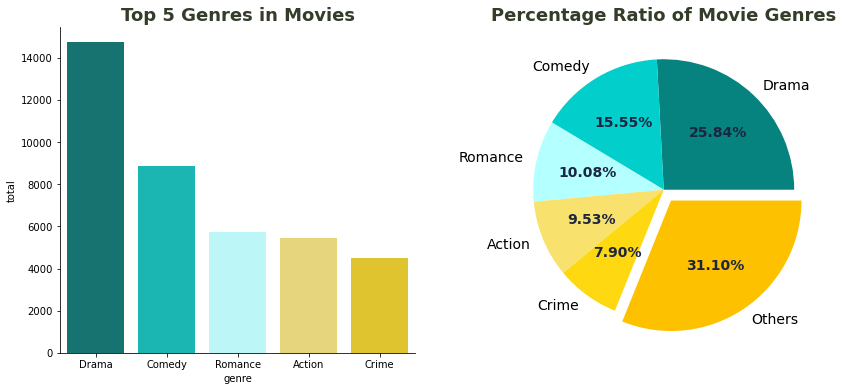

In [38]:
# Create list of genres
genres_list = []
for i in imdb_wiki['genres']:
    genres_list.extend(i.split(','))

# Instantiate plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Create barplot
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], 
                 palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

# Create pie chart
df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')

wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), 
                                       explode=[0,0,0,0,0,0.1], 
                                       colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off');

From the above, we can see a few takeaways:

* Drama is the single most dominant genre with over 14000 movies.
* Out of the top 5 genres, there are still many genres in the dataset. They hold 31.11% of the total genres of the movies.

Let's see if we can look at all of the genres in a different format.

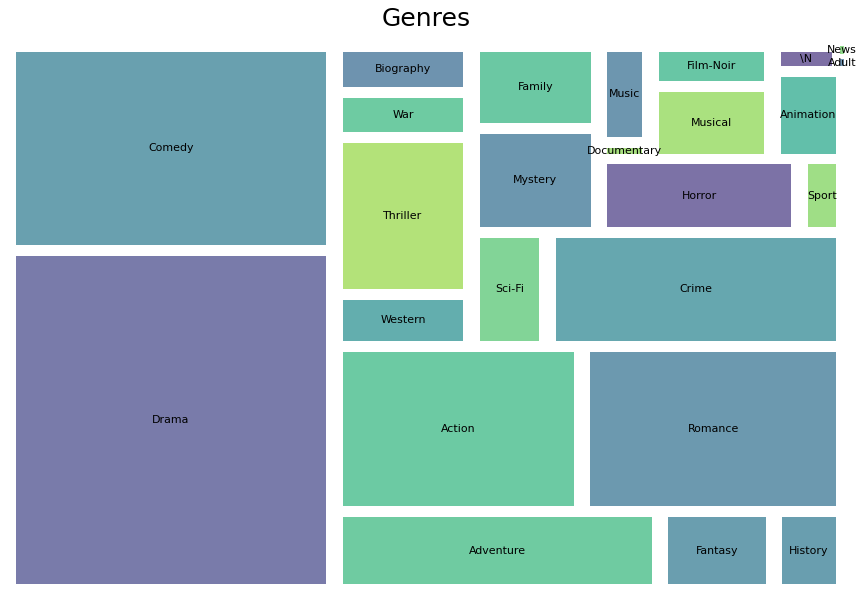

In [39]:
genres_info = Counter(genres_list)

plt.figure(figsize=(15, 10))
plt.title("Genres", fontsize=25, pad=20)
squarify.plot(genres_info.values(), label=genres_info.keys(), text_kwargs={'fontsize':11}, 
              bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off");

We have the same data as our first visual, but this time we can see all of the genres. 

Next, let's take a look to see what year our movies were released.

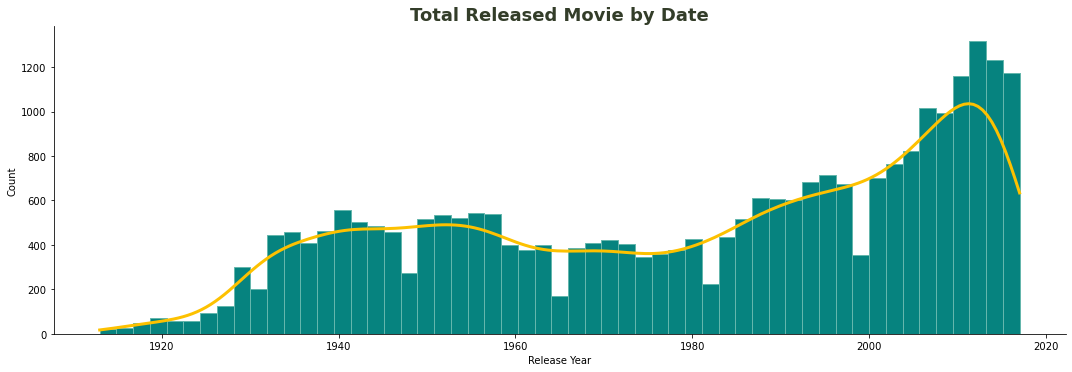

In [40]:
# Change Release Year to integer
imdb_wiki['Release Year'] = imdb_wiki['Release Year'].astype(int)

sns.displot(data=imdb_wiki, x='Release Year', kind='hist', kde=True, bins=55,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)

plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29');

As we can see above, our dataset is skewed right. Once again, this logically makes sense as before because more content is produced in recent years.

## Modeling

Now that we have a good understanding of our dataframe, we can start creating our second model. As a reminder, we are going to create a model that takes in the below as inputs.

* The genre of the movie
* The director of the movie
* Major stars and cast

In the below cells, we are going to use a vectorizer to build document vectors. One thing we address is that actors could have the same first name, for example such as *Tom Hanks* and *Tom Cruise*. These are clearly 2 different people but as of now, our vectorizer would just look at the name *Tom* as a separate entity. 

Therefore, we are going to strip the spaces between the genres, cast, and director's names. Therefore, in our example we will now have *tomhanks* and *tomcruise* to differentiate between our two actors. 

In [41]:
# Function to sanitize data to prevent ambiguity. 
# Removes spaces and converts to lowercase
def sanitize(x):
    if isinstance(x, list):
        #Strip spaces and convert to lowercase
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [42]:
#Apply the generate_list function to cast, director and genres
for feature in ['Cast', 'genres', 'primaryName']:
    imdb_wiki[feature] = imdb_wiki[feature].apply(sanitize)

In [43]:
# Replace commas with spaces
imdb_wiki['Cast'] = imdb_wiki['Cast'].str.replace(',', ' ')
imdb_wiki['genres'] = imdb_wiki['genres'].str.replace(',', ' ')

Let's take a look to see what the `Cast` looks like now.

In [44]:
imdb_wiki.iloc[11251]['Cast']

'timallen tomhanks(voices)'

Great! We can see that it worked, however we do not want the `(voices)` to be included attached to `tomhanks`. Let's remove that.

In [45]:
# Remove paranthesis and everything inside
# imdb_wiki['Cast'] = imdb_wiki['Cast'].str.replace(r"\(.*\)","")

In [46]:
# Check if it worked
imdb_wiki.iloc[11251]['Cast']

'timallen tomhanks(voices)'

In [47]:
#Function that creates a soup out of the desired metadata
def create_soup(x):
    return x['Cast'] + ' ' + x['genres'] + ' ' + x['primaryName']

In [48]:
# Create the new soup feature
imdb_wiki['soup'] = imdb_wiki.apply(create_soup, axis=1)

# Preview results
imdb_wiki.head()

,Release Year,Title,Cast,Plot,Clean_Plot,tconst,runtimeMinutes,genres,averageRating,numVotes,primaryName,soup
0,1913,Atlantis,,"Dr. Friedrich von Kammacher (Olaf Fønss), a su...",dr friedrich von kammacher olaf fønss a surgeo...,tt0002646,121,drama,6.6,424,augustblom,drama augustblom
1,1914,The Battle of the Sexes,donaldcrisp liliangish,"Frank Andrews (Donald Crisp) is a well-to-do, ...",frank andrews donald crisp is a welltodo middl...,tt0003665,50,drama,6.2,99,d.w.griffith,donaldcrisp liliangish drama d.w.griffith
2,1914,Brewster's Millions,edwardabeles sydneydeane josephsingleton,Wealthy Edwin Peter Brewster disowns his son R...,wealthy edwin peter brewster disowns his son r...,tt0003698,\N,comedy,6.7,50,cecilb.demille,edwardabeles sydneydeane josephsingleton comed...
3,1914,Brewster's Millions,edwardabeles sydneydeane josephsingleton,Wealthy Edwin Peter Brewster disowns his son R...,wealthy edwin peter brewster disowns his son r...,tt0003698,\N,comedy,6.7,50,oscarapfel,edwardabeles sydneydeane josephsingleton comed...
4,1914,The Call of the North,robertedeson theodoreroberts,"Graehme, Ned Stewart's father was accused of a...",graehme ned stewarts father was accused of adu...,tt0003743,\N,adventure drama,5.2,45,cecilb.demille,robertedeson theodoreroberts adventure drama c...


Now that we have our `[soup]` created, we are able to create the document vectors, compute similarity scores, and build our metadata-based recommender function.

This recommendation function will follow the basic same process as before, however we will be using a `CountVectorizer` instead of the `TF-IDFVectorizer` because the `TF-IDFVectorizer` will give less weight to actors and directors who have been in a large number of movies. We do not want to penalize artists for appearing in additional movies.

Unfortunately, the `CountVectorizer` will require us to use the more computationally expensive `cosine_similarity` function to compute the scores.

In [49]:
# Instantiate the vectorizer
count = CountVectorizer(stop_words='english')

# Fit the vectorizer on `soup` and transform it
count_matrix = count.fit_transform(imdb_wiki['soup'])

# Preview the shape
count_matrix.shape

(26779, 30805)

In [50]:
# Compute cosine similarity score
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# Create variable `indices2` to pull the index of each movie
indices2 = pd.Series(imdb_wiki.index, index=imdb_wiki['Title'])

In [51]:
get_recommendations('Toy Story', cosine_sim2, imdb_wiki, indices2)

,Title
12055,Toy Story 2
12860,The Polar Express
8566,Raggedy Ann & Andy: A Musical Adventure
8567,Raggedy Ann & Andy: A Musical Adventure
9994,Pound Puppies and the Legend of Big Paw
10280,DuckTales the Movie: Treasure of the Lost Lamp
10708,Tom and Jerry: The Movie
11568,Hercules
11569,Hercules
15110,The Wild Life


We can look to comapre these results from our first model's results.

In [52]:
get_recommendations('Toy Story', cosine_sim, plots_df, indices)

,Title
13574,Toy Story 2
5342,Destination Meatball
15948,Toy Story 3
5203,Puny Express
16619,Nebraska
16606,LUV
3731,The Barber of Seville
2811,Girl from Havana
6608,Mr. B Natural
22145,It's a Boy Girl Thing


Toy Story 2 is obviously very close to Toy Story, but we can see that we do have a lot of differences from there. The `cosine_sim2` model has more children movies due to the genre, while `cosine_sim` has more plot based movies.

# Ratings Model

Now we are going to create our third type of model. One of the most basic ideas for a model is just to rank movies off of their respective ratings. However, doing a model like this has a few caveats:

* Ratings do not look at the the popularity of a movie. For example, a movie with a rating of 8.0 from 10 voters will be considered "better" than a movie with a rating of 7.9 from 10,000 voters.
* This metric will also favor movies that a smaller number of voters with extremely high ratings.

Before continuing, let's take a look at the top rated movies in our dataset.

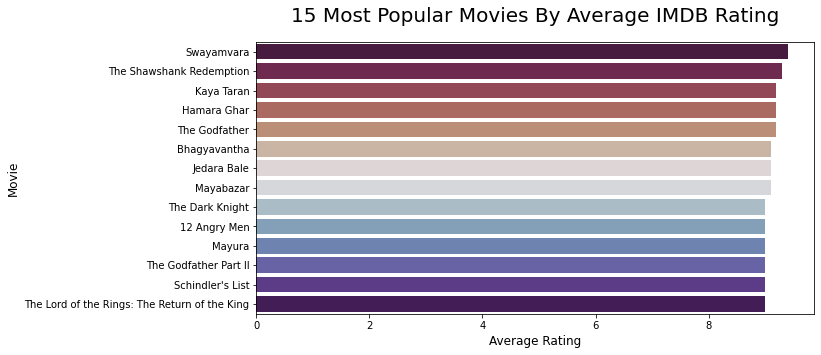

In [53]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,5))

# Get top 15 movies
top_15_popular = imdb_wiki.sort_values(by='averageRating', ascending=False)[:15]

# Plot the data
sns.barplot(data= top_15_popular, x='averageRating', y='Title', palette='twilight_shifted_r')
plt.title("15 Most Popular Movies By Average IMDB Rating", fontsize=20, pad=20)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Movie', fontsize=12);

Due to the shortcomings of just doing a model based on the average rating, we need to come up with a weighted rating that looks at the average rating as well as the number of votes that a movie has accumulated. A system like this will ensure that a movie with a 7.9 rating from 10,000 voters will get a higher quality score than a movie with a 8.0 rating from 10 voters.

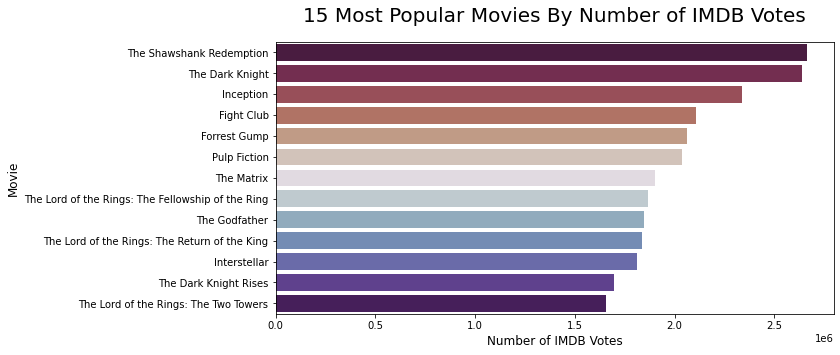

In [54]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,5))

# Get top 15 movies
top_15_popular = imdb_wiki.sort_values(by='numVotes', ascending=False)[:15]

# Plot the data
sns.barplot(data= top_15_popular, x='numVotes', y='Title', palette='twilight_shifted_r')
plt.title("15 Most Popular Movies By Number of IMDB Votes", fontsize=20, pad=20)
plt.xlabel('Number of IMDB Votes', fontsize=12)
plt.ylabel('Movie', fontsize=12);

As we can see above, these two charts have slight differences. *The Shawshank Redemption* and *The Dark Knight* are the two most voted on movies on IMDB. However the highest average rated movies are *Swayamvara* and *The Shawshank Redemption*.

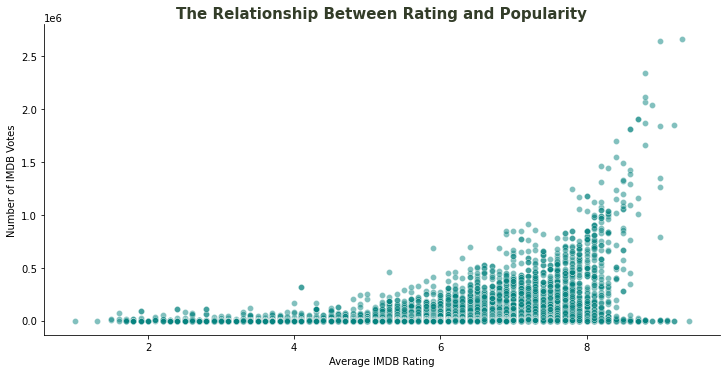

In [55]:
sns.relplot(data=imdb_wiki, x='averageRating', y='numVotes', alpha=.5, aspect=2, color='#06837f')

plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')
plt.xlabel('Average IMDB Rating')
plt.ylabel('Number of IMDB Votes');

As we can see in the chart above, there is a slight relationship between the average IMDB rating and the number of IMDB votes. Due to this, we are going to come up with a weighted rating that looks at both metrics. This can be represented by the below equation:

\begin{equation} \text Weighted Rating (\bf WR) = \left({{\bf v} \over {\bf v} + {\bf m}} \cdot R\right) + \left({{\bf m} \over {\bf v} + {\bf m}} \cdot C\right) \end{equation}

In this equation,

* v is the number of votes for the movie (`numVotes`)
* m is the minumum votes required to be listed in the chart
* R is the average rating for the movie (`averageRating`)
* C is the mean vote across the whole dataset

We already have the values for `v` and `R`. Additionally, we are able to directly calculate `C` from this information. One part we will need to figure out is an appropriate value for `m`. We can address this later.

First we will calculate `C`, the mean rating across all movies.

In [56]:
# Calculate C
C = imdb_wiki['averageRating'].mean()

# Display result
print(C.round(3))

6.214


From this, we can observe that an average rating for a movie in our IMDB dataset is around 6.2 on a scale of 10. Let's go ahead and calculate the score for all of the movies in our dataframe.

In [57]:
# Minumum votes to be in n-th percentile
m = 0

In [58]:
def weighted_rating(data, m=m, C=C):
    
    # Get v
    v = data['numVotes']
    
    # Get R
    R = data['averageRating']
    
    # Calculation based on the formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [59]:
# Run function
imdb_wiki['Score'] = imdb_wiki.apply(weighted_rating, axis=1)

In [60]:
# Sort by top scores
imdb_wiki = imdb_wiki.sort_values('Score', ascending=False)

# Print top 10 movies
imdb_wiki[['Title', 'averageRating', 'numVotes', 'Score']].head(10)

,Title,averageRating,numVotes,Score
22505,Swayamvara,9.4,16,9.4
11036,The Shawshank Redemption,9.3,2663062,9.3
21844,Kaya Taran,9.2,7,9.2
20410,Hamara Ghar,9.2,6,9.2
8039,The Godfather,9.2,1845515,9.2
22533,Bhagyavantha,9.1,82,9.1
22497,Jedara Bale,9.1,49,9.1
24805,Mayabazar,9.1,5149,9.1
22498,Jedara Bale,9.1,49,9.1
17849,The Dark Knight,9.0,2636054,9.0


Well this is interesting. We have a lot of movies here that have basically no votes. Let's try running this again but include movies that are in the top 75% of votes received. We can use pandas for this.

In [61]:
# Minumum votes to be in n-th percentile
m = imdb_wiki['numVotes'].quantile(0.25)

print('25th Percentile:', m.round(0))

25th Percentile: 237.0


We will start by looking at movies that are in the 25th percentile of movies, meaning they need to have at least 237 votes. We will create a new dataframe to ensure that we do not mess with our original data.

In [62]:
# Filter movies in the top 75%
m25_df = imdb_wiki.copy().loc[imdb_wiki['numVotes'] > m]

# Display shape of new dataframe
m25_df.shape

(20077, 13)

In [63]:
imdb_wiki.shape

(26779, 13)

As we can see here, we filtered out roughly 25% of our movies, or movies that have received less than 237 votes. Let's take a look at the top results.

In [64]:
# Sort by top scores
m25_df = m25_df.sort_values('Score', ascending=False)

# Print top 10 movies
m25_df[['Title', 'averageRating', 'numVotes', 'Score']].head(10)

,Title,averageRating,numVotes,Score
11036,The Shawshank Redemption,9.3,2663062,9.3
8039,The Godfather,9.2,1845515,9.2
24805,Mayabazar,9.1,5149,9.1
10848,Schindler's List,9.0,1348587,9.0
24947,Aha Naa Pellanta,9.0,3056,9.0
22570,Om,9.0,3531,9.0
12659,The Lord of the Rings: The Return of the King,9.0,1836112,9.0
22502,Bangarada Manushya,9.0,947,9.0
8257,The Godfather Part II,9.0,1264131,9.0
22510,Mayura,9.0,309,9.0


This looks significantly better. Let's try doing this one last time but only look at movies that are in the top 10% of number of votes.

In [65]:
# Minumum votes to be in n-th percentile
m = imdb_wiki['numVotes'].quantile(0.90)

# Filter movies in the top 90%
m90_df = imdb_wiki.copy().loc[imdb_wiki['numVotes'] > m]

# Sort by top scores
m90_df = m90_df.sort_values('Score', ascending=False)

# Print top 10 movies
m90_df[['Title', 'averageRating', 'numVotes', 'Score']].head(10)

,Title,averageRating,numVotes,Score
11036,The Shawshank Redemption,9.3,2663062,9.3
8039,The Godfather,9.2,1845515,9.2
17849,The Dark Knight,9.0,2636054,9.0
6130,12 Angry Men,9.0,786416,9.0
8257,The Godfather Part II,9.0,1264131,9.0
10848,Schindler's List,9.0,1348587,9.0
12659,The Lord of the Rings: The Return of the King,9.0,1836112,9.0
11015,Pulp Fiction,8.9,2038357,8.9
11954,Fight Club,8.8,2108400,8.8
12487,The Lord of the Rings: The Two Towers,8.8,1657960,8.8


That's great. Now we have the ability to generate recommendations based on the average rating and number of votes, while taking into account a minumum number of votes needed to recommend.

# Collaborative Filtering Recommendation System

We are now going to move onto a new type of recommendation system using collaborative filtering. All of the previous recommender systems were content based, meaning they would recommend items based on analyizing item attributes and finding similar items. Pivoting to collaborative filtering, we will now create a recommendation system based on a user's previous behaviors.

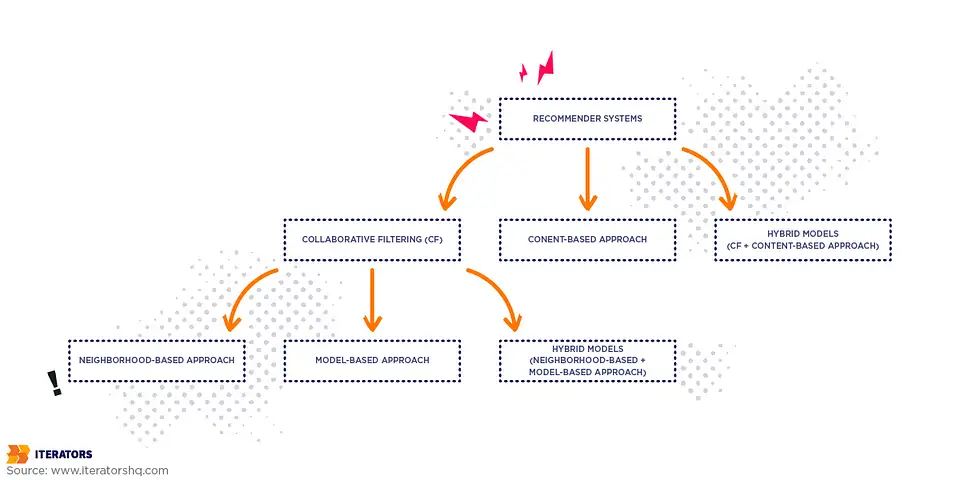

The goal of collaborative filtering systems is to provide the best user experience. Big companies such as Netflix and Amazon use these everyday and are a staple of their business model. 

## MovieLens 100K Data

There are 4 files within the MovieLens 100K dataset:

  * `links`
  * `movies`
  * `ratings`
  * `tags` - DONT THINK WE NEED THIS

In [66]:
# Load the data
links_df = pd.read_csv('Data/MovieLens/ml-latest-small/links.csv')

# Preview the data
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [67]:
# Load the data
movies_df = pd.read_csv('Data/MovieLens/ml-latest-small/movies.csv')

# Preview the data
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [68]:
# Load the data
ratings_df = pd.read_csv('Data/MovieLens/ml-latest-small/ratings.csv')

# Preview the data
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [69]:
# # Load the data
# tags_df = pd.read_csv('Data/MovieLens/ml-latest-small/tags.csv')

# # Preview the data
# tags_df.head()

Now let's try merging together the three dataframes from the MovieLens 100K dataset. Luckily they have an unique column in common - `movieId`.

In [70]:
# Merge the datasets on `movieId`
movielens_df = pd.merge(links_df, movies_df, on='movieId')

# Merge the datasets on `movieId`
movielens_df = pd.merge(movielens_df, ratings_df, on='movieId')

# Preview the results
movielens_df

,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp
0,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...,...,...
100831,193581,5476944,432131.0,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,5914996,445030.0,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,6397426,479308.0,Flint (2017),Drama,184,3.5,1537109805
100834,193587,8391976,483455.0,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [71]:
# Checking for missing values
movielens_df.isna().sum()

movieId       0
imdbId        0
tmdbId       13
title         0
genres        0
userId        0
rating        0
timestamp     0
dtype: int64

We won't be using the `tmdbId` column so we can drop that entirely from our dataframe.

In [72]:
# Drop the column
movielens_df.drop('tmdbId', axis=1, inplace=True)

In [73]:
# Checking if it worked
movielens_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   imdbId     100836 non-null  int64  
 2   title      100836 non-null  object 
 3   genres     100836 non-null  object 
 4   userId     100836 non-null  int64  
 5   rating     100836 non-null  float64
 6   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 6.2+ MB


Unfortunately we do not have a 100% distinct column in both the `movielens_df` and `imdb_wiki` dataframes. 

However, the column `imdbId` from `movielens_df` is appropriate to use for matching this dataset to the `imdb_wiki` dataset using `tconst`. Let's take a look at this below:

In [74]:
# Preview the first line
movielens_df[:1]

,movieId,imdbId,title,genres,userId,rating,timestamp
0,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703


As we can see, Toy Story has an `imdbId` of `114709`. What is even better is that this matches up with the link to Toy Story on IMDB's website.

> Toy Story: https://www.imdb.com/title/tt0114709/

Let's see if Toy Story appears in our `imdb_wiki` dataframe.

In [75]:
# Check for `imdbId` value
imdb_wiki.loc[imdb_wiki['tconst'].str.contains('114709')]

,Release Year,Title,Cast,Plot,Clean_Plot,tconst,runtimeMinutes,genres,averageRating,numVotes,primaryName,soup,Score
11251,1995,Toy Story,timallen tomhanks(voices),In a world where toys are living things who pr...,in a world where toys are living things who pr...,tt0114709,81,adventure animation comedy,8.3,989855,johnlasseter,timallen tomhanks(voices) adventure animation ...,8.3


Well that actually works well for us. Before going any further, let's try looking at some additional examples:

In [76]:
# Pull another random sample
movielens_df[3695:3700]

,movieId,imdbId,title,genres,userId,rating,timestamp
3695,111,75314,Taxi Driver (1976),Crime|Drama|Thriller,411,4.0,835532253
3696,111,75314,Taxi Driver (1976),Crime|Drama|Thriller,414,5.0,961516639
3697,111,75314,Taxi Driver (1976),Crime|Drama|Thriller,415,4.5,1382470177
3698,111,75314,Taxi Driver (1976),Crime|Drama|Thriller,418,4.5,1461866063
3699,111,75314,Taxi Driver (1976),Crime|Drama|Thriller,419,4.0,1321659216


In [77]:
# Cross reference the `movieId`
imdb_wiki.loc[imdb_wiki['tconst'].str.contains('75314')]

,Release Year,Title,Cast,Plot,Clean_Plot,tconst,runtimeMinutes,genres,averageRating,numVotes,primaryName,soup,Score
8486,1976,Taxi Driver,robertdeniro jodiefoster cybillshepherd harvey...,"Travis Bickle, a 26-year-old honorably dischar...",travis bickle a 26yearold honorably discharged...,tt0075314,114,crime drama,8.2,828016,martinscorsese,robertdeniro jodiefoster cybillshepherd harvey...,8.2
19262,2016,My Best Friend's Wedding,shuqi fengshaofeng victoriasong yeqing rhydian...,A successful fashion editor realizes she has r...,a successful fashion editor realizes she has r...,tt5275314,91,drama romance,5.1,338,feihongchen,shuqi fengshaofeng victoriasong yeqing rhydian...,5.1


Well that is interesting. We have two `tconst` matches for our one `movieId` column.

After doing a little digging, it is easy to tell that all of the movies we are looking for start with the `tconst` of `tt0`. Let's drop all of the rows from our `imdb_df` that do not include that code:

In [78]:
# Preview the original shape
imdb_wiki.shape

(26779, 13)

In [79]:
# Filter out movies not containing `tt0`
imdb_wiki = imdb_wiki.loc[imdb_wiki['tconst'].str.contains('tt0')]

print(imdb_wiki.shape, '\n')
imdb_wiki.head()

(20676, 13) 



,Release Year,Title,Cast,Plot,Clean_Plot,tconst,runtimeMinutes,genres,averageRating,numVotes,primaryName,soup,Score
11036,1994,The Shawshank Redemption,timrobbins morganfreeman jameswhitmore clancyb...,"In 1947 Portland, Maine, banker Andy Dufresne ...",in 1947 portland maine banker andy dufresne is...,tt0111161,142,drama,9.3,2663062,frankdarabont,timrobbins morganfreeman jameswhitmore clancyb...,9.3
21844,2004,Kaya Taran,seemabiswas angadbedi neelambaribhattacharya n...,Preet is a shy young journalist visiting a con...,preet is a shy young journalist visiting a con...,tt0470399,107,drama,9.2,7,sashikumar,seemabiswas angadbedi neelambaribhattacharya n...,9.2
20410,1964,Hamara Ghar,dilipraj surekha sonalmehta rekharao nanapalsi...,Children from different social backgrounds and...,children from different social backgrounds and...,tt0150816,\N,\n,9.2,6,khwajaahmadabbas,dilipraj surekha sonalmehta rekharao nanapalsi...,9.2
8039,1972,The Godfather,marlonbrando alpacino jamescaan robertduvall j...,"In 1945, at his daughter Connie's wedding, Vit...",in 1945 at his daughter connies wedding vito c...,tt0068646,175,crime drama,9.2,1845515,francisfordcoppola,marlonbrando alpacino jamescaan robertduvall j...,9.2
22533,1981,Bhagyavantha,masterlohith aarathi jaijagadish leelavathi k....,The movie stars and revolves around the life o...,the movie stars and revolves around the life o...,tt0260737,\N,\n,9.1,82,rangab.s.,masterlohith aarathi jaijagadish leelavathi k....,9.1


It appears that we filtered out about ~20% of the rows from our `imdb_wiki`. However, now we should not have any overlaps when we are trying to merge our two datasets. 

In order to merge the two datasets, we need to change the `imdbId` column into an string so it matches `tconst`. Let's drop the first 3 digits from our `tconst` column so it will match `imdbId` and then change the `imdbId` column to a string.

In [80]:
# Slice each column in `tconst`
imdb_wiki['tconst'] = imdb_wiki['tconst'].str[3:]

# Preview the results
imdb_wiki.head()

,Release Year,Title,Cast,Plot,Clean_Plot,tconst,runtimeMinutes,genres,averageRating,numVotes,primaryName,soup,Score
11036,1994,The Shawshank Redemption,timrobbins morganfreeman jameswhitmore clancyb...,"In 1947 Portland, Maine, banker Andy Dufresne ...",in 1947 portland maine banker andy dufresne is...,111161,142,drama,9.3,2663062,frankdarabont,timrobbins morganfreeman jameswhitmore clancyb...,9.3
21844,2004,Kaya Taran,seemabiswas angadbedi neelambaribhattacharya n...,Preet is a shy young journalist visiting a con...,preet is a shy young journalist visiting a con...,470399,107,drama,9.2,7,sashikumar,seemabiswas angadbedi neelambaribhattacharya n...,9.2
20410,1964,Hamara Ghar,dilipraj surekha sonalmehta rekharao nanapalsi...,Children from different social backgrounds and...,children from different social backgrounds and...,150816,\N,\n,9.2,6,khwajaahmadabbas,dilipraj surekha sonalmehta rekharao nanapalsi...,9.2
8039,1972,The Godfather,marlonbrando alpacino jamescaan robertduvall j...,"In 1945, at his daughter Connie's wedding, Vit...",in 1945 at his daughter connies wedding vito c...,068646,175,crime drama,9.2,1845515,francisfordcoppola,marlonbrando alpacino jamescaan robertduvall j...,9.2
22533,1981,Bhagyavantha,masterlohith aarathi jaijagadish leelavathi k....,The movie stars and revolves around the life o...,the movie stars and revolves around the life o...,260737,\N,\n,9.1,82,rangab.s.,masterlohith aarathi jaijagadish leelavathi k....,9.1


In [81]:
# Change `imdbId` to a string
movielens_df['imdbId'] = movielens_df['imdbId'].astype('str')

In [82]:
# Merge the two datasets
movielens_imdb = pd.merge(movielens_df, imdb_wiki, left_on='imdbId', right_on='tconst')

# Preview the results
movielens_imdb.head()

,movieId,imdbId,title,genres_x,userId,rating,timestamp,Release Year,Title,Cast,Plot,Clean_Plot,tconst,runtimeMinutes,genres_y,averageRating,numVotes,primaryName,soup,Score
0,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,1995,Toy Story,timallen tomhanks(voices),In a world where toys are living things who pr...,in a world where toys are living things who pr...,114709,81,adventure animation comedy,8.3,989855,johnlasseter,timallen tomhanks(voices) adventure animation ...,8.3
1,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1995,Toy Story,timallen tomhanks(voices),In a world where toys are living things who pr...,in a world where toys are living things who pr...,114709,81,adventure animation comedy,8.3,989855,johnlasseter,timallen tomhanks(voices) adventure animation ...,8.3
2,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,1995,Toy Story,timallen tomhanks(voices),In a world where toys are living things who pr...,in a world where toys are living things who pr...,114709,81,adventure animation comedy,8.3,989855,johnlasseter,timallen tomhanks(voices) adventure animation ...,8.3
3,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,1995,Toy Story,timallen tomhanks(voices),In a world where toys are living things who pr...,in a world where toys are living things who pr...,114709,81,adventure animation comedy,8.3,989855,johnlasseter,timallen tomhanks(voices) adventure animation ...,8.3
4,1,114709,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,1995,Toy Story,timallen tomhanks(voices),In a world where toys are living things who pr...,in a world where toys are living things who pr...,114709,81,adventure animation comedy,8.3,989855,johnlasseter,timallen tomhanks(voices) adventure animation ...,8.3


In [83]:
movielens_imdb.columns

Index(['movieId', 'imdbId', 'title', 'genres_x', 'userId', 'rating',
       'timestamp', 'Release Year', 'Title', 'Cast', 'Plot', 'Clean_Plot',
       'tconst', 'runtimeMinutes', 'genres_y', 'averageRating', 'numVotes',
       'primaryName', 'soup', 'Score'],
      dtype='object')

We can see that we have a good amount of duplicated and unnecessary columns, let's go ahead and filter out the columns we actually want to keep.

In [84]:
# Filter out columns we want
movielens_imdb_df = movielens_imdb[['Title', 'imdbId', 'Release Year', 'Plot', 'soup', 'genres_x',
                                    'userId', 'rating', 'runtimeMinutes', 'averageRating', 'numVotes', 'Score']]

# Preview new dataframe
print('Dataframe Length:', movielens_imdb_df.shape[0])
movielens_imdb_df.head()

Dataframe Length: 59022


,Title,imdbId,Release Year,Plot,soup,genres_x,userId,rating,runtimeMinutes,averageRating,numVotes,Score
0,Toy Story,114709,1995,In a world where toys are living things who pr...,timallen tomhanks(voices) adventure animation ...,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,81,8.3,989855,8.3
1,Toy Story,114709,1995,In a world where toys are living things who pr...,timallen tomhanks(voices) adventure animation ...,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,81,8.3,989855,8.3
2,Toy Story,114709,1995,In a world where toys are living things who pr...,timallen tomhanks(voices) adventure animation ...,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,81,8.3,989855,8.3
3,Toy Story,114709,1995,In a world where toys are living things who pr...,timallen tomhanks(voices) adventure animation ...,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,81,8.3,989855,8.3
4,Toy Story,114709,1995,In a world where toys are living things who pr...,timallen tomhanks(voices) adventure animation ...,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,81,8.3,989855,8.3


Let's make a copy of this dataframe that includes only the information we need for our collaborative filtering recommendation system.

In [85]:
# Slice out columns we want
collab_df = movielens_imdb_df[['Title', 'userId', 'imdbId', 'rating']]

# Preview results
collab_df.head()

,Title,userId,imdbId,rating
0,Toy Story,1,114709,4.0
1,Toy Story,5,114709,4.0
2,Toy Story,7,114709,4.5
3,Toy Story,15,114709,2.5
4,Toy Story,17,114709,4.5


### Train Test Split

Our `collab_df` contains user ratings that range from 0.5 to 5.0. Therefore, we can model this problem as an instance of supervised learning where we need to predict the rating, given a user and a movie. Although the ratings can only take in ten discrete values, we will model this as a regression problem.

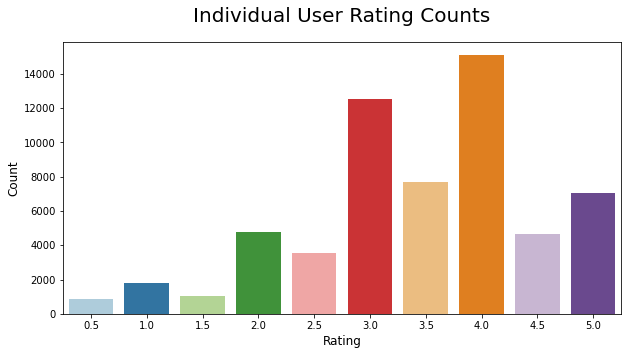

In [86]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,5))

sns.countplot(data=movielens_imdb_df, x='rating', palette='Paired')
plt.title("Individual User Rating Counts", fontsize=20, pad=20)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12);

Think about an example where the rating given by a user to a movie is a 5.0. A classification model will not distinguish between the predicted ratings of 1.0 and 4.0 but rather treate both as misclassified. However, a regression model will penalize the 1.0 more than the 4.0, which is what we want to happen.

We are going to split the `collab_df` so that 75% of a user's ratings are in the training dataset and 25% are in the testing dataset, which will require us do the `train_test_split` in a bit of an odd way. We will assume that the `userId` field is the target variable (or y) and that the other columns are the predictor variables (or X). We will perform a `train_test_split` and set stratify to `y` to ensure that the proportion of each class is the same in the training and testing datasets.

In [87]:
#Assign X and y 
X = collab_df.copy()
y = collab_df['userId']

# Perform train test split with random_state = 32
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32, stratify=y)

### Evaluation

We are going to use root mean squared error to assess our model performance as it is the most commonly used performance metric for regressors. We are going to create a function that returns to square root value.

In [88]:
# Create function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Now we are going to make a baseline collaborative filter model. This model will take in a `userId` and `imdbId` as input and return a float between 0.5 and 5.0. We make our baseline model will return a 3.0 regardless of `userId` and `imdbId`.

In [89]:
# Baseline model that returns 3.0
def baseline(userId, imdbId):
    return 3.0

To test how effective this model is, we will compute the RMSE for all user-IMDB pairs in the test dataset:

In [90]:
def score(cf_model):
    
    # List of user-IMDB tuples in testing data
    pairs = zip(X_test['userId'], X_test['imdbId'])
    
    # Predict the rating for every tuple
    y_pred = np.array([cf_model(user, movie) for (user, movie) in pairs])
    
    # Get actual ratings
    y_true = np.array(X_test['rating'])
    
    # Return score
    return rmse(y_true, y_pred)

Now let's compute the RMSE for our baseline model:

In [91]:
# Calculate score
score(baseline)

1.1410280327568652

Great. We got a score of 1.141. For the models that we will build after this, we will try to obtain a RMSE that is less than this baseline model.

## User-Based Collaborative Filtering

We are first going to create a user-based collaborative filter. This type of filter finds users that are similar to a particular user and then recommends products that those users have liked.

We are first going to build a ratings matrix where each row represents a user and each column represents a movie. Therefore, the value in the i<sup>th</sup> row and j<sup>th</sup> column will denote the rating given by user i and movie j.

In [92]:
# Ratings matrix
r_matrix = X_train.pivot_table(values='rating', index='userId', columns='imdbId')

r_matrix.head()

imdbId,100029,100046,100050,100053,100054,100087,100114,100133,100140,100142,...,981227,985694,986233,986263,988045,988047,988595,990407,993842,997047
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now have a new dataframe where each row is a user and each column is a movie. We can see that most values are NaN, which makese sense as most users will not have seen most movies.

## Mean Model

We will start by building a simple collaborative filter. This will take in a `userId` and `imdbId` and output the mean rating for the movie by everyone who has rated it. This filter will not distinguish between users meaning each user is assigned equal weight. 

It is also possible that some movies will only be in the test set and not the training set, therefore we will give a default rating of 3.0 like our baseline model:

In [93]:
def cf_user_mean(userId, imdbId):
    
    # Check if movie is in our r_matrix
    if imdbId in r_matrix:
        
        # Compute the mean
        mean_rating = r_matrix[imdbId].mean()
        
    else:
        
        # Default 3.0
        mean_rating = 3.0
        
    return mean_rating

In [94]:
# RMSE for Mean model
score(cf_user_mean)

0.9629955053948778

Fantastic! We can see that the score obtained for this model is lower (and better) than our baseline model.

| **Type of Model** | **RMSE** |
|:-----------------:|:--------:|
|   Baseline Model  |   1.141  |
|     Mean Model    |   0.963  |

## Weighted Mean Model

It makes more sense to give more preference to those users whose ratings are similar to the user in question rather than users whose ratings are not. 

Therefore, we are going to change our previous model and introduce a weight coefficient. This will be the similarity metric from scikit learn `cosine_similarity`.

This tool does not work with NaN values so we will convert all of those to zero.

In [95]:
# Copy ratings matrix with Nan as O
r_matrix_dummy = r_matrix.copy().fillna(0)

In [96]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(r_matrix_dummy, r_matrix_dummy)

# Make pandas dataframe
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix_dummy.index, columns=r_matrix_dummy.index)

# Preview results
cosine_sim.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.088042,0.0,0.184772,0.212683,0.158697,0.094938,0.146237,0.0,0.046694,...,0.081585,0.179845,0.196777,0.124603,0.067483,0.115929,0.264995,0.260810,0.107102,0.124772
2,0.088042,1.000000,0.0,0.012410,0.043148,0.058754,0.058945,0.000000,0.0,0.056828,...,0.273643,0.039189,0.018794,0.000000,0.000000,0.050654,0.000000,0.095686,0.066680,0.132754
3,0.000000,0.000000,1.0,0.000000,0.000000,0.004137,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.050317,0.000000,0.000000,0.008106,0.000000,0.002957,0.000000,0.073931
4,0.184772,0.012410,0.0,1.000000,0.152532,0.098451,0.136609,0.091610,0.0,0.057881,...,0.056458,0.165241,0.281763,0.081660,0.046162,0.133648,0.082003,0.144413,0.042600,0.117084
5,0.212683,0.043148,0.0,0.152532,1.000000,0.251701,0.085787,0.238896,0.0,0.045444,...,0.064057,0.269860,0.095557,0.246353,0.104750,0.071896,0.126915,0.126730,0.148119,0.074597


Now we can calculate the weighted mean scores for our model. However, we need to only consider cosine similarity scores that have a corresponding, non-null rating. In other words, we need to avoid all users who have not rated the specific movie in question.

In [140]:
for user in r_matrix:

    print(cosine_sim[user])
#     sim_scores = cosine_sim[user]

#     m_ratings = r_matrix[imdbId]

#     idx = m_ratings[m_ratings.isnull()].index

#     m_ratings = m_ratings.dropna()

#     sim_scores = sim_scores.drop(idx)

#     wm = np.dot(sim_scores, m_ratings) / sim_scores.sum()
    
#     wm

KeyError: '100029'

In [141]:
def cf_user_wmean(userId, imdbId):
    
    # Check if movie is in matrix
    if imdbId in r_matrix:
        
        # Get similarity score
        sim_scores = cosine_sim[userId]
        
        # Get the user ratings for the movie
        m_ratings = r_matrix[imdbId]
        
        # Extract the indices containing NaN
        idx = m_ratings[m_ratings.isnull()].index
        
        # Drop the NaN values from m_ratings series
        m_ratings = m_ratings.dropna()
        
        # Drop the corresponding cosine scores
        sim_scores = sim_scores.drop(idx)
        
        # Compute weighted mean
        wmean_rating = np.dot(sim_scores, m_ratings) / sim_scores.sum()

    else:
        
        # Default to 3.0 if no information
        wmean_rating = 3.0
        
    return wmean_rating

In [142]:
score(cf_user_wmean)

<ipython-input-141-e4517aa60a2c>:22: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, m_ratings) / sim_scores.sum()


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Item-Based Collaborative Filtering

This type of model is the same as the last type, except users now play the role that the items played. According to [Towards Data Science](https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d) it was developed by Amazon in 1998 and plays a great role in Amazon's success.

At the core, item-based collaborative filters are all about finding items similar to the ones that a user has already liked. For example, let's assume that Maddie enjoyed movies 'A', 'B', and 'C'. We will then search for movies that are similar to those three movies. If we found a movie 'D', that is highly similar to one, two, or three of 'A', 'B', or 'C', we would recommend movie 'D' to Maddie because it is very similar to movies she already watched.

We can use a few different filters for the models that we will use in this part of the notebook.

### Clustering

Using clustering, such as k-means, it is possible to group users into a cluster and only take the users from the same clusters into consideration when predicting ratings. We will use a [K-Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) given a user a movie:

1. Find the k-nearest neighbors of users who have rated the movie
2. Output the average rating of the nearest users for the movie

All of this can be doing using the `surprise` library, which stands for **Simple Python Recommendation System Engine**. From the [Surprise website](https://surpriselib.com/), the library was designed with the following purposes in mind:

* Give users perfect control over their experiments. To this end, a strong emphasis is laid on documentation, which we have tried to make as clear and precise as possible by pointing out every detail of the algorithms.
* Alleviate the pain of Dataset handling. Users can use both built-in datasets (Movielens, Jester), and their own custom datasets.
* Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.
* Make it easy to implement new algorithm ideas.
* Provide tools to evaluate, analyse and compare the algorithms’ performance. Cross-validation procedures can be run very easily using powerful CV iterators (inspired by scikit-learn excellent tools), as well as exhaustive search over a set of parameters.

In [103]:
# Get rid of `Title` column
surprise_df = collab_df[['userId', 'imdbId', 'rating']]

In [104]:
# Define Reader Object
reader = Reader(rating_scale=(0.5, 5))

# Create dataset to be used
data = Dataset.load_from_df(surprise_df, reader)

# Define object
knn = KNNBasic()

# Evaluate the performance in RMSE
knn_basic = cross_validate(knn, data, measures=['RMSE'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [105]:
# Display results
for i in knn_basic.items():
    print(i)

print('Test RMSE:', np.mean(knn_basic['test_rmse']))

('test_rmse', array([0.89398278, 0.89353721, 0.89962375, 0.89374974, 0.8921612 ]))
('fit_time', (0.10522055625915527, 0.12053155899047852, 0.12169337272644043, 0.12794065475463867, 0.12004709243774414))
('test_time', (0.8117833137512207, 0.7889101505279541, 0.7716495990753174, 0.8159592151641846, 0.8040585517883301))
Test RMSE: 0.8946109372254533


|      **Type of Model**      | **RMSE** |
|:---------------------------:|:--------:|
| Baseline Model (User Based) |   1.141  |
|   Mean Model (User Based)   |   0.963  |
|    KNN Basic (Item Based)   |   0.896  |

We can see here that the `cross_validate` used a five fold cross validation score. We can also see here that we received a RMSE of 0.896 which is by far the best score we have obtained so far. 

We can try one other KNN object, the KNN Baseline.

In [106]:
# Define object
knn = KNNBaseline()

# Evaluate the performance in RMSE
knn_baseline = cross_validate(knn, data, measures=['RMSE'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [107]:
# Display results
for i in knn_baseline.items():
    print(i)

print('Test RMSE:', np.mean(knn_baseline['test_rmse']))

('test_rmse', array([0.84233875, 0.81213425, 0.82724378, 0.83390538, 0.83475777]))
('fit_time', (0.188309907913208, 0.1720566749572754, 0.16806340217590332, 0.22455930709838867, 0.18055129051208496))
('test_time', (0.9542102813720703, 0.9422283172607422, 1.015866756439209, 0.9345729351043701, 0.9188446998596191))
Test RMSE: 0.8300759862134779


|      **Type of Model**      | **RMSE** |
|:---------------------------:|:--------:|
| Baseline Model (User Based) |   1.141  |
|   Mean Model (User Based)   |   0.963  |
|    KNN Basic (Item Based)   |   0.894  |
|  KNN Baseline (Item Based)  |   0.830  |

Once again, we beat our best performing model with a RMSE of 0.830.

In [108]:
# Define object
knn = KNNWithMeans()

# Evaluate the performance in RMSE
knn_with_means = cross_validate(knn, data, measures=['RMSE'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [109]:
# Display results
for i in knn_with_means.items():
    print(i)

print('Test RMSE:', np.mean(knn_with_means['test_rmse']))

('test_rmse', array([0.8663283 , 0.85064979, 0.85262168, 0.8478428 , 0.8491586 ]))
('fit_time', (0.12176942825317383, 0.13097000122070312, 0.12159848213195801, 0.12121033668518066, 0.12168550491333008))
('test_time', (0.8319013118743896, 0.8385100364685059, 0.7933871746063232, 0.7758545875549316, 0.8929500579833984))
Test RMSE: 0.853320234353402


|      **Type of Model**      | **RMSE** |
|:---------------------------:|:--------:|
| Baseline Model (User Based) |   1.141  |
|   Mean Model (User Based)   |   0.963  |
|    KNN Basic (Item Based)   |   0.894  |
|  KNN Baseline (Item Based)  |   0.830  |
| KNN With Means (Item Based) |   0.853  |

This model did not perform as well as our baseline KNN model.

### Singular-Value Decomposition

Principal Component Analysis (or PCA) transforms a *m x n* matrix into n, m-dimensional vectors (or principal components) in such a way that each component is orthogonal to the next component. It also constructs these components in such a way that the first component holds the most variance (or information), followed by the second component, and so on.

The classic version of Singular-Value Decomposition (SVD), like most other machine learning algorithms, does not work with sparse matrices. However, Simon Funk figured out a workaround for this problem, and his solution led to one of the most famous solutions in the world of recommender systems.

Funk's system took in the sparse ratings matrix, A, and constructed two dense user- and item-embedding matrices, U and V respectively. These dense matrices directly gave us the predictions for all the missing values in the original matrix, A.

Fortunately, there is a nice package in surprise to help implement this model.

In [110]:
# Define object
svd = SVD()

# Evaluate the performance in RMSE
svd_baseline = cross_validate(svd, data, measures=['RMSE'])

In [111]:
# Display results
for i in svd_baseline.items():
    print(i)

print('Test RMSE:', np.mean(svd_baseline['test_rmse']))

('test_rmse', array([0.81289121, 0.82919337, 0.82389782, 0.82417604, 0.83701894]))
('fit_time', (2.0575528144836426, 1.966749668121338, 2.0559942722320557, 2.000663995742798, 2.2232441902160645))
('test_time', (0.05694222450256348, 0.056507110595703125, 0.10681343078613281, 0.058000802993774414, 0.06579089164733887))
Test RMSE: 0.8254354739068802


|      **Type of Model**      | **RMSE** |
|:---------------------------:|:--------:|
| Baseline Model (User Based) |   1.141  |
|   Mean Model (User Based)   |   0.963  |
|    KNN Basic (Item Based)   |   0.894  |
|  KNN Baseline (Item Based)  |   0.830  |
| KNN With Means (Item Based) |   0.853  |
|       SVD (Item Based)      |   0.827  |

Great! We can see here that we beat our previous KNN models with our first SVD model. Now we can try a `GridSearchCV` to see if we can beat this SVD Baseline model.

In [112]:
# Set up parameters
params = {'n_factors': [20, 50, 100, 150],
         'reg_all': [0.02, 0.05, 0.1]}

# Perform a gridsearch with SVD
gs_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1)

# Fit on our data
gs_svd.fit(data)

In [113]:
print(gs_svd.best_score)
print(gs_svd.best_params)

{'rmse': 0.8245697020657022, 'mae': 0.6264953890469693}
{'rmse': {'n_factors': 150, 'reg_all': 0.02}, 'mae': {'n_factors': 150, 'reg_all': 0.02}}


|         **Type of Model**        | **RMSE** |
|:--------------------------------:|:--------:|
|    Baseline Model (User Based)   |   1.141  |
|      Mean Model (User Based)     |   0.963  |
|      KNN Basic (Item Based)      |   0.894  |
|     KNN Baseline (Item Based)    |   0.830  |
|    KNN With Means (Item Based)   |   0.853  |
|         SVD (Item Based)         |   0.827  |
| SVD With GridSearch (Item Based) |   0.825  |

We can see here that our GridSearch helped us *slightly* beat the previous SVD model with a RMSE of 0.825.

## Making Recommendations

While it is great that we achieved a low RMSE, this is in no way interpretable to people. Let's start off by making a simple prediction for an individual user and item. First we will build out our trainset and fit our best SVD model with the proper parameters.

In [114]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  609 

Number of items:  2908


In [115]:
# Instatiate the object
svd = SVD(n_factors=150, reg_all=0.02)

# Fit SVD
svd.fit(dataset)

In [116]:
# Predict for a user
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=3.440493465751861, details={'was_impossible': False})

This prediction is a tuple and the values can be accessed via indexing. 

## Obtaining User Ratings

Wouldn't it be great if we could get a recommendation specifically tailored to individual preferences? That what we can do with the below function `movie_rater()`. This will take in the below parameters:

* `movielens_imdb_df`: Dataframe containing name of the movie, genres, and movie ID
* `num`: number of ratings
* `genre`: specific genre of where to draw movies from

In [117]:
def movie_rater(movielens_imdb_df, num, genre=None):
    userID = 612
    rating_list = []
    
    while num > 0:
        if genre:
            movie = movielens_imdb_df[movielens_imdb_df['genres_x'].str.contains(genre)].sample(1)

        else:
            movie = movielens_imdb_df.sample(1)
        
        print('Movie Title:', movie['Title'].values[0], '\n', 'Released:', movie['Release Year'].values[0])
        
        rating = input('''How do you rate this movie on a scale of 1-5, press 'n' if you have not seen :\n''')
        
        if rating == 'n':
            continue
        
        else:
            rating_one_movie = {'userId':userID, 'imdbId': movie['imdbId'].values[0], 'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list  

In [118]:
user_rating = movie_rater(movielens_imdb_df, 10)

Movie Title: Scream 
 Released: 1996
How do you rate this movie on a scale of 1-5, press 'n' if you have not seen :
2
Movie Title: Jackie Brown 
 Released: 1997
How do you rate this movie on a scale of 1-5, press 'n' if you have not seen :
n
Movie Title: The Scorpion King 
 Released: 2002
How do you rate this movie on a scale of 1-5, press 'n' if you have not seen :
n
Movie Title: Chicken Run 
 Released: 2000
How do you rate this movie on a scale of 1-5, press 'n' if you have not seen :
n
Movie Title: Vicky Cristina Barcelona 
 Released: 2008
How do you rate this movie on a scale of 1-5, press 'n' if you have not seen :
n
Movie Title: Terminator 3: Rise of the Machines 
 Released: 2003
How do you rate this movie on a scale of 1-5, press 'n' if you have not seen :
2
Movie Title: Hellboy II: The Golden Army 
 Released: 2008
How do you rate this movie on a scale of 1-5, press 'n' if you have not seen :
2
Movie Title: In the Line of Fire 
 Released: 1993
How do you rate this movie on a sca

### Making Predictions with the New Ratings

Now that we have the new ratings, we can make predictions for this new user. We will do the below steps:

* add the new ratings to the original ratings DataFrame, read into a `surprise` dataset 
* train a model using the new combined DataFrame
* make predictions for the user
* order those predictions from highest rated to lowest rated
* return the top n recommendations with the text of the actual movie (rather than just the index number) 

In [119]:
# Create new dataframe with columns needed
new_df = movielens_imdb_df[['userId', 'imdbId', 'rating']]

# Convert `user_rating` to DataFrame
user_rating = pd.DataFrame(user_rating)

# Add the new ratings to the new ratings DataFrame
new_ratings_df = pd.concat([new_df, user_rating], ignore_index=True)

new_data = Dataset.load_from_df(new_ratings_df, reader)

In [120]:
# Train a model using the new combined DataFrame
svd_ = SVD(n_factors= 100, reg_all=0.02)

# Fit the model
svd_.fit(new_data.build_full_trainset())

In [121]:
# Make predictions for the user
list_of_movies = []
for m_id in new_df['imdbId'].unique():
    list_of_movies.append( (m_id, svd_.predict(1000, m_id)[3]))

In [122]:
# Order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [123]:
# Return the top n recommendations using the 
def recommended_movies(user_ratings, movie_title_df, n):
    
    for idx, rec in enumerate(ranked_movies):
        
        title = movielens_imdb_df.loc[movielens_imdb_df['imdbId'] == rec[0]]

        print('Recommendation #', idx+1, ':', title['Title'].values[0], '-', title['Release Year'].values[0], '\n')
        
        n-= 1
        
        if n == 0:
            break

Let's try it out!

In [124]:
recommended_movies(ranked_movies, movielens_imdb_df, 5)

Recommendation # 1 : The Shawshank Redemption - 1994 

Recommendation # 2 : Fight Club - 1999 

Recommendation # 3 : Miller's Crossing - 1990 

Recommendation # 4 : Man Bites Dog - 1992 

Recommendation # 5 : The Usual Suspects - 1995 



# Hybrid Recommendation

In [125]:
from surprise.model_selection import KFold
from surprise.prediction_algorithms import CoClustering, slope_one, NormalPredictor

In [126]:
rawTrain, rawholdout = train_test_split(surprise_df, test_size=0.25 )
# when importing from a DF, you only need to specify the scale of the ratings.
reader = Reader(rating_scale=(0.5, 5)) 
#into surprise:
data = Dataset.load_from_df(rawTrain,reader)
holdout = Dataset.load_from_df(rawholdout,reader)

In [127]:
kSplit = KFold(n_splits=10, shuffle=True)

In [128]:
sim_options = sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }

collabKNN = KNNBasic(k=40, sim_options=sim_options) #try removing sim_options. You'll find memory errors.

rmseKNN = []
rmseSVD = []
rmseCo = []
rmseSlope = []

for trainset, testset in kSplit.split(data): #iterate through the folds.
    collabKNN.fit(trainset)
    predictionsKNN = collabKNN.test(testset)
    rmseKNN.append(accuracy.rmse(predictionsKNN, verbose=True))#get root means squared error

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9600
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9414
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9472
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9545
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9368
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9427
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9479
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9552
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9622
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9579


In [129]:
funkSVD = SVD(n_factors=30, n_epochs=10, biased=True)

In [130]:
min_error = 1

for trainset, testset in kSplit.split(data): #iterate through the folds.
    funkSVD.fit(trainset)
    predictionsSVD = funkSVD.test(testset)
    rmseSVD.append(accuracy.rmse(predictionsSVD,verbose=True)) #get root means squared error

RMSE: 0.8611
RMSE: 0.8494
RMSE: 0.8730
RMSE: 0.8511
RMSE: 0.8646
RMSE: 0.8678
RMSE: 0.8609
RMSE: 0.8596
RMSE: 0.8560
RMSE: 0.8723


In [131]:
coClus = CoClustering(n_cltr_u=4, n_cltr_i=4, n_epochs=25) 

for trainset, testset in kSplit.split(data): #iterate through the folds.
    coClus.fit(trainset)
    predictionsCoClus = coClus.test(testset)
    rmseCo.append(accuracy.rmse(predictionsCoClus, verbose=True))#get root means squared error

<ipython-input-131-0ed3e4c94b6c>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coClus.fit(trainset)


RMSE: 0.9342
RMSE: 0.9527
RMSE: 0.9264
RMSE: 0.9421
RMSE: 0.9154
RMSE: 0.9291
RMSE: 0.9125
RMSE: 0.9522
RMSE: 0.9135
RMSE: 0.9249


In [132]:
slopeOne = slope_one.SlopeOne()

In [133]:
for trainset, testset in kSplit.split(data): #iterate through the folds.
    slopeOne.fit(trainset)
    predictionsSlope = slopeOne.test(testset)
    rmseSlope.append(accuracy.rmse(predictionsSlope,verbose=True))#get root means squared error

<ipython-input-133-0fc20d813386>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  slopeOne.fit(trainset)


RMSE: 0.8839
RMSE: 0.8697
RMSE: 0.8615
RMSE: 0.8740
RMSE: 0.8525
RMSE: 0.8448
RMSE: 0.8578
RMSE: 0.8753
RMSE: 0.8632
RMSE: 0.8801


In [134]:
compiledPredictions = rmseKNN + rmseSVD + rmseCo + rmseSlope

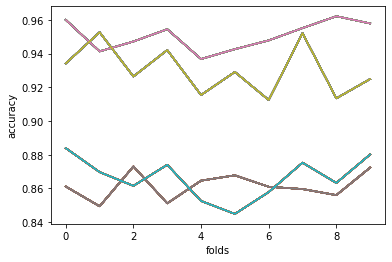

In [135]:
for prediction in compiledPredictions:
    modelPrediction = plt.plot(rmseKNN, label='knn')
    modelPrediction = plt.plot(rmseSVD, label='svd')
    modelPrediction = plt.plot(rmseCo, label='cluster')
    modelPrediction = plt.plot(rmseSlope, label='slope')

    modelPrediction = plt.xlabel('folds')
    modelPrediction = plt.ylabel('accuracy')

In [138]:
class HybridFacto(NormalPredictor):
    def __init__(self, epochs, learning_rate, num_models):
        self.alpha = np.array([1/(num_models)]*(num_models))
        self.epochs = epochs
        self.learning_rate = learning_rate
    
    def fit(self,holdout):
        holdout= holdout.build_full_trainset().build_testset()
        for epoch in range(self.epochs):
            
            predictions = np.array([collabKNN.test(holdout),funkSVD.test(holdout),coClus.test(holdout),slopeOne.test(holdout)])
            maeGradient = [accuracy.rmse(prediction) for prediction in predictions]
            newalpha = self.alpha - learning_rate * maeGradient  
            #convergence check:
            if newalpha - self.alpha < 0.001:
                break
            self.alpha = newalpha
            
    def estimate(self,u,i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')
        algoResults = np.array([collabKNN.predict(u,i),funkSVD.predict(u,i),coClus.predict(u,i),slopeOne.predict(u,i)])
        return np.sum(np.dot(self.alpha,algoResults))

In [139]:
hybrid = HybridFacto(epochs=10, learning_rate=0.05, num_models=4)

hybrid.fit(holdout)

rmseHyb = []

for trainset, testset in kSplit.split(data): #iterate through the folds.
    
    predhybrid = Hyhybrid.test(testset)
    
    rmseHyb.append(accuracy.rmse(predhybrid))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
for prediction in compiledPredictions:
    modelPrediction = plt.plot(rmseKNN,label='knn')
    modelPrediction = plt.plot(rmseSVD,label='svd')
    modelPrediction = plt.plot(rmseCo,label='cluster')
    modelPrediction = plt.plot(rmseSlope,label='slope')
    modelPrediction = plt.plot(rmseHyb,label='Hybrid')

    modelPrediction = plt.xlabel('folds')
    modelPrediction = plt.ylabel('accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)